# Testing an MLJ random forest classifier with the penguins dataset

In [38]:
# Load packages
using MLJ, CSV, DataFrames, VegaLite

In [39]:
# Import CSV to dataframe, select some columns, drop missing values
penguins = CSV.read("penguins.csv", missingstring="NA", DataFrame) |>
x -> select(x, :species, :bill_length_mm, :bill_depth_mm, :flipper_length_mm, :body_mass_g) |>
dropmissing

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
,String15,Float64,Float64,Int64,Int64
1,Adelie,39.1,18.7,181,3750
2,Adelie,39.5,17.4,186,3800
3,Adelie,40.3,18.0,195,3250
4,Adelie,36.7,19.3,193,3450
5,Adelie,39.3,20.6,190,3650
6,Adelie,38.9,17.8,181,3625
7,Adelie,39.2,19.6,195,4675
8,Adelie,34.1,18.1,193,3475
9,Adelie,42.0,20.2,190,4250


In [40]:
schema(penguins)

┌───────────────────┬──────────┬────────────┐
│ _.names           │ _.types  │ _.scitypes │
├───────────────────┼──────────┼────────────┤
│ species           │ String15 │ Textual    │
│ bill_length_mm    │ Float64  │ Continuous │
│ bill_depth_mm     │ Float64  │ Continuous │
│ flipper_length_mm │ Int64    │ Count      │
│ body_mass_g       │ Int64    │ Count      │
└───────────────────┴──────────┴────────────┘
_.nrows = 342


In [41]:
# Modify data schema
coerce!(penguins,
:species            => Multiclass,
:flipper_length_mm  => Continuous,
:body_mass_g        => Continuous);

In [42]:
# Check data schema
schema(penguins)

┌───────────────────┬────────────────────────────────────┬───────────────┐
│ _.names           │ _.types                            │ _.scitypes    │
├───────────────────┼────────────────────────────────────┼───────────────┤
│ species           │ CategoricalValue{String15, UInt32} │ Multiclass{3} │
│ bill_length_mm    │ Float64                            │ Continuous    │
│ bill_depth_mm     │ Float64                            │ Continuous    │
│ flipper_length_mm │ Float64                            │ Continuous    │
│ body_mass_g       │ Float64                            │ Continuous    │
└───────────────────┴────────────────────────────────────┴───────────────┘
_.nrows = 342


In [43]:
# Split predictors (X) and response variable (y)
y, X = unpack(penguins, ==(:species), _ -> true; rng=1010);

In [44]:
# Search for models that match the data scitype and are pure Julia
for m in models(matching(X, y))
    if m.is_pure_julia == true
        println(rpad(m.name, 40), "($(m.package_name))")
    end
end

AdaBoostStumpClassifier                 (DecisionTree)
BayesianLDA                             (MultivariateStats)
BayesianSubspaceLDA                     (MultivariateStats)
ConstantClassifier                      (MLJModels)
DecisionTreeClassifier                  (BetaML)
DecisionTreeClassifier                  (DecisionTree)
DeterministicConstantClassifier         (MLJModels)
EvoTreeClassifier                       (EvoTrees)
GaussianNBClassifier                    (NaiveBayes)
KNNClassifier                           (NearestNeighborModels)
KernelPerceptronClassifier              (BetaML)
LDA                                     (MultivariateStats)
LogisticClassifier                      (MLJLinearModels)
MultinomialClassifier                   (MLJLinearModels)
NeuralNetworkClassifier                 (MLJFlux)
PegasosClassifier                       (BetaML)
PerceptronClassifier                    (BetaML)
RandomForestClassifier                  (BetaML)
RandomForestClassifier     

In [45]:
# Search for random forest classifier models that match the data scitype and are pure Julia
[m for m in models(matching(X, y)) if m.name == "RandomForestClassifier" && m.is_pure_julia == true]

2-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = RandomForestClassifier, package_name = BetaML, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )

In [46]:
# Create a model using the DecisionTree package
model = @load RandomForestClassifier pkg="DecisionTree" add=true verbosity=0

MLJDecisionTreeInterface.RandomForestClassifier

In [47]:
# Get model info
info(model)

Random forest classifier.
→ based on [DecisionTree](https://github.com/bensadeghi/DecisionTree.jl).
→ do `@load RandomForestClassifier pkg="DecisionTree"` to use the model.
→ do `?RandomForestClassifier` for documentation.
(name = "RandomForestClassifier",
 package_name = "DecisionTree",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (),
 docstring = "Random forest classifier.\n→ based on [DecisionTree](https://github.com/bensadeghi/DecisionTree.jl).\n→ do `@load RandomForestClassifier pkg=\"DecisionTree\"` to use the model.\n→ do `?RandomForestClassifier` for documentation.",
 fit_data_scitype = Tuple{Table{var"#s53"} where var"#s53"<:Union{AbstractVector{var"#s52"} where var"#s52"<:Count, AbstractVector{var"#s52"} where var"#s52"<:OrderedFactor, AbstractVector{var"#s52"} where var"#s52"<:Continuous}, AbstractVector{var"#s41"} where var"#s41"<:Finite},
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),

In [48]:
# Instantiate the random forest classifier
model_rf = model()

RandomForestClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = -1,
    n_trees = 10,
    sampling_fraction = 0.7,
    pdf_smoothing = 0.0,
    rng = Random._GLOBAL_RNG())

In [49]:
# Create an MLJ machine (model + data)
mach_rf = machine(model_rf, X, y)

Machine{RandomForestClassifier,…} trained 0 times; caches data
  args: 
    1:	Source @785 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @009 ⏎ `AbstractVector{Multiclass{3}}`


In [50]:
# Split train/test
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=1010)

([58, 318, 278, 89, 200, 38, 219, 332, 237, 133  …  336, 126, 177, 14, 65, 333, 252, 183, 239, 196], [62, 176, 264, 212, 129, 310, 181, 101, 151, 211  …  69, 241, 7, 316, 315, 145, 158, 110, 43, 179])

In [51]:
# Fit the model
fit!(mach_rf, rows=train)

┌ Info: Training Machine{RandomForestClassifier,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{RandomForestClassifier,…} trained 1 time; caches data
  args: 
    1:	Source @785 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @009 ⏎ `AbstractVector{Multiclass{3}}`


In [52]:
# Check trained parameters
fitted_params(mach_rf)

(forest = Ensemble of Decision Trees
Trees:      10
Avg Leaves: 9.3
Avg Depth:  5.6,)

In [53]:
# Make predictions
y_test_pred = predict(mach_rf, rows=test)

103-element MLJBase.UnivariateFiniteVector{Multiclass{3}, String15, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(Adelie=>0.3, Chinstrap=>0.7, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.9, Chinstrap=>0.1, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.1, Chinstrap=>0.9, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.7, Chinstrap=>0.1, Gentoo=>0.2)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.9, Chinstrap=>0.1, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>1.0, Chinstrap=>0.0, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>1.0, Chinstrap=>0.0, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.0, Chinstrap=>1.0, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.7, Chinstrap=>0.3, Gentoo=>0.0)
 UnivariateFinite{Multiclass{3}}(Adelie=>1.0, Chinstrap=>0.0, Gentoo=>0.0)
 ⋮
 UnivariateFinite{Multiclass{3}}(Adelie=>0.0, Chinstrap=>0.1, Gentoo=>0.9)
 UnivariateFinite{Multiclass{3}}(Adelie=>0.0, Chinstrap=>0.0, Gentoo=>1.0)
 Univariate

In [54]:
# Extract best prediction
# predict(mach_rf, rows=test)
mode.(y_test_pred)

103-element CategoricalArrays.CategoricalArray{String15,1,UInt32}:
 "Chinstrap"
 "Adelie"
 "Chinstrap"
 "Adelie"
 "Adelie"
 "Adelie"
 "Adelie"
 "Chinstrap"
 "Adelie"
 "Adelie"
 ⋮
 "Gentoo"
 "Gentoo"
 "Chinstrap"
 "Adelie"
 "Chinstrap"
 "Adelie"
 "Adelie"
 "Adelie"
 "Adelie"

In [55]:
# Calculate the average cross entropy between y_test_pred and y_test
cross_entropy(y_test_pred, y[test]) |> mean |> x -> round(x, digits=3)

0.074

# Model tuning

In [56]:
# Define a range for the :max_depth parameters
r_maxdepth = range(model_rf, :max_depth, lower=1, upper=5)
r_ntrees = range(model_rf, :n_trees, values=[100, 200, 300, 400, 500])

NominalRange(n_trees = 100, 200, 300, ...)

In [57]:
# Wrap the model into a TunedModel
tm = TunedModel(model=model_rf, ranges=[r_maxdepth, r_ntrees], measure=cross_entropy)

ProbabilisticTunedModel(
    model = RandomForestClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = LogLoss(tol = 2.220446049250313e-16),
    weights = nothing,
    operation = nothing,
    range = MLJBase.ParamRange{Int64}[NumericRange(1 ≤ max_depth ≤ 5; origin=3.0, unit=2.0), NominalRange(n_trees = 100, 200, 300, ...)],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
   

In [58]:
# Fit the tuned model
m = machine(tm, X, y)
fit!(m)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


┌ Info: Attempting to evaluate 25 models.
└ @ MLJTuning C:\Users\julio\.julia\packages\MLJTuning\bjRHJ\src\tuned_models.jl:680
Evaluating over 25 metamodels:   8%[==>                      ]  ETA: 0:00:02

Evaluating over 25 metamodels:  12%[===>                     ]  ETA: 0:00:02

Evaluating over 25 metamodels:  16%[====>                    ]  ETA: 0:00:02

Evaluating over 25 metamodels:  20%[=====>                   ]  ETA: 0:00:02

Evaluating over 25 metamodels:  24%[======>                  ]  ETA: 0:00:02

Evaluating over 25 metamodels:  28%[=======>                 ]  ETA: 0:00:02

Evaluating over 25 metamodels:  32%[========>                ]  ETA: 0:00:01

Evaluating over 25 metamodels:  36%[=========>               ]  ETA: 0:00:01

Evaluating over 25 metamodels:  40%[==========>              ]  ETA: 0:00:01

Evaluating over 25 metamodels:  44%[===========>             ]  ETA: 0:00:01

Evaluating over 25 metamodels:  48%[============>            ]  ETA: 0:00:01

Evaluating over 25 metamodels:  52%[=============>           ]  ETA: 0:00:01

Evaluating over 25 metamodels:  56%[==============>          ]  ETA: 0:00:01

Evaluating over 25 metamodels:  60%[===============>         ]  ETA: 0:00:01

Evaluating over 25 metamodels:  64%[================>        ]  ETA: 0:00:01

Evaluating over 25 metamodels:  68%[=================>       ]  ETA: 0:00:01

Evaluating over 25 metamodels:  72%[==================>      ]  ETA: 0:00:01

Evaluating over 25 metamodels:  76%[===================>     ]  ETA: 0:00:00

Evaluating over 25 metamodels:  80%[====================>    ]  ETA: 0:00:00

Evaluating over 25 metamodels:  84%[=====================>   ]  ETA: 0:00:00

Evaluating over 25 metamodels:  88%[======================>  ]  ETA: 0:00:00

Evaluating over 25 metamodels:  92%[=======================> ]  ETA: 0:00:00

Evaluating over 25 metamodels:  96%[========================>]  ETA: 0:00:00

Evaluating over 25 metamodels: 100%[=========================] Time: 0:00:01


Machine{ProbabilisticTunedModel{Grid,…},…} trained 1 time; caches data
  args: 
    1:	Source @409 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @449 ⏎ `AbstractVector{Multiclass{3}}`


In [59]:
# Inspect fitted parameters
fitted_params(m).best_model.max_depth, fitted_params(m).best_model.n_trees

(5, 500)

In [60]:
# Use operation=predict_mode to care only about the mode and the misclassification rate
tm = TunedModel(model=model_rf, ranges=[r_maxdepth, r_ntrees], operation=predict_mode, measure=misclassification_rate)
m = machine(tm, X, y)
fit!(m)
fitted_params(m).best_model.max_depth, fitted_params(m).best_model.n_trees

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Attempting to evaluate 25 models.
└ @ MLJTuning C:\Users\julio\.julia\packages\MLJTuning\bjRHJ\src\tuned_models.jl:680
Evaluating over 25 metamodels:   8%[==>                      ]  ETA: 0:00:01

Evaluating over 25 metamodels:  12%[===>                     ]  ETA: 0:00:01

Evaluating over 25 metamodels:  16%[====>                    ]  ETA: 0:00:01

Evaluating over 25 metamodels:  20%[=====>                   ]  ETA: 0:00:02

Evaluating over 25 metamodels:  28%[=======>                 ]  ETA: 0:00:01

Evaluating over 25 metamodels:  32%[========>                ]  ETA: 0:00:01

Evaluating over 25 metamodels:  36%[=========>               ]  ETA: 0:00:01

Evaluating over 25 metamodels:  40%[==========>              ]  ETA: 0:00:01

Evaluating over 25 metamodels:  44%[===========>             ]  ETA: 0:00:01

Evaluating over 25 metamodels:  48%[============>            ]  ETA: 0:00:01

Evaluating over 25 metamodels:  52%[=============>           ]  ETA: 0:00:01

Evaluating over 25 metamodels:  56%[==============>          ]  ETA: 0:00:01

Evaluating over 25 metamodels:  60%[===============>         ]  ETA: 0:00:01

Evaluating over 25 metamodels:  64%[================>        ]  ETA: 0:00:01

Evaluating over 25 metamodels:  68%[=================>       ]  ETA: 0:00:00

Evaluating over 25 metamodels:  72%[==================>      ]  ETA: 0:00:00

Evaluating over 25 metamodels:  76%[===================>     ]  ETA: 0:00:00

Evaluating over 25 metamodels:  80%[====================>    ]  ETA: 0:00:00

Evaluating over 25 metamodels:  84%[=====================>   ]  ETA: 0:00:00

Evaluating over 25 metamodels:  88%[======================>  ]  ETA: 0:00:00

Evaluating over 25 metamodels:  92%[=======================> ]  ETA: 0:00:00

Evaluating over 25 metamodels:  96%[========================>]  ETA: 0:00:00

Evaluating over 25 metamodels: 100%[=========================] Time: 0:00:01


(5, 400)

In [61]:
# Get the model report
model_report = report(m)
model_report.best_history_entry.measurement[1]

0.02912621359223301

In [62]:
# Get plotting data
res = model_report.plotting
res_df = DataFrame(max_depth=res.parameter_values[:, 1],
                   n_trees=res.parameter_values[:, 2],
                   miss_rate=res.measurements)
res_df[!, "maxdepth_ntrees"] = ["$(row[:max_depth])-$(row[:n_trees])" for row in eachrow(res_df)]

25-element Vector{String}:
 "3-100"
 "5-400"
 "1-400"
 "4-400"
 "5-500"
 "5-100"
 "4-300"
 "1-500"
 "2-100"
 "3-400"
 ⋮
 "2-200"
 "3-500"
 "1-300"
 "1-200"
 "2-300"
 "5-200"
 "2-400"
 "1-100"
 "5-300"

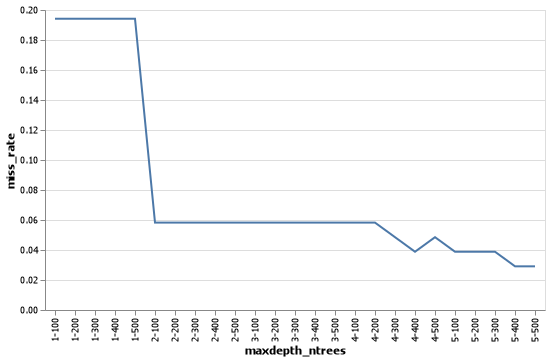

In [74]:
# Plot results
res_df |>
@vlplot(
    :line,
    x=:maxdepth_ntrees,
    y=:miss_rate,
    width=500,
    height=300)